# Weight initialization

## follow the explanation here

https://adventuresinmachinelearning.com/weight-initialization-tutorial-tensorflow/


In [1]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/acubillosunal/UBM-DEEP-LEARNING-1/main/init.py
import init; init.init(force_download=False); 

In [2]:
import sys
if 'google.colab' in sys.modules:
    print ("setting tensorflow version in colab")
    %tensorflow_version 2.x
import tensorflow as tf
tf.__version__

2024-03-22 12:37:50.190351: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-22 12:37:50.247070: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-22 12:37:50.247100: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-22 12:37:50.249469: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-22 12:37:50.262545: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-22 12:37:50.262957: I tensorflow/core/platform/cpu_feature_guard.cc:1

'2.15.0'

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Image
%matplotlib inline

In [4]:
mnist = pd.read_csv("local/data/mnist1.5k.csv.gz", compression="gzip", header=None).values
X=mnist[:,1:785]/255.
y=mnist[:,0]
print("dimension de las imagenes y las clases", X.shape, y.shape)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
X_train = X_train
X_test  = X_test
y_train_oh = np.eye(10)[y_train]
y_test_oh  = np.eye(10)[y_test]
print(X_train.shape, y_train_oh.shape)

dimension de las imagenes y las clases (1500, 784) (1500,)
(1200, 784) (1200, 10)


# load data and train a simple model

In [5]:
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, concatenate, Input
from tensorflow.keras.backend import clear_session
from tensorflow import keras
import tensorflow as tf
import tensorflow.keras.backend as K
tf.keras.backend.set_floatx('float32')

In [6]:
def get_model(input_dim=784, output_dim=10, layer_sizes=[10]*6, activation="relu", sigma=1):
    
    model = Sequential()
    init1k = keras.initializers.RandomNormal(mean=.0, stddev=sigma, seed=None)
    init1b = keras.initializers.RandomNormal(mean=.0, stddev=sigma, seed=None)

    model.add(Dense(layer_sizes[0], activation=activation, input_dim=input_dim, name="Layer_%02d_Input"%(0),
                    kernel_initializer=init1k,
                    bias_initializer=init1b,
                    dtype=tf.float64
                ))

   
    for i, hsize in enumerate(layer_sizes[1:]):
        model.add(Dense(hsize, activation=activation, name="Layer_%02d_Hidden"%(i+1), dtype=tf.float64))
   
    model.add(Dense(output_dim, activation="softmax", name="Layer_%02d_Output"%(len(layer_sizes)), dtype=tf.float64))
        
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.reset_states()
    return model

def get_gradients_functions(model):
    T_input     = model.input                                        
    T_outputs   = [layer.output for layer in model.layers]         
    T_weights   = model.trainable_weights
    T_outputs   = [layer.output for layer in model.layers]

    F_outputs   = [K.function([T_input], [out]) for out in T_outputs]    

    def get_gradients_functions(model):
        r = []
        for i in range(len(model.trainable_variables)):
            def f(X,y,i=eval("i")):
                v = model.trainable_variables[i]
                with tf.GradientTape(persistent=True) as t:
                    loss = model.loss_functions[0]( model(X), y)
                return t.gradient(loss,v).numpy()
            r.append(f)
        return r

    F_gradients = get_gradients_functions(model)

    return T_input, T_outputs, T_weights, F_outputs, F_gradients

In [7]:
model = get_model(layer_sizes=[20,15,15], activation="sigmoid", sigma=20)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_00_Input (Dense)      (None, 20)                15700     
                                                                 
 Layer_01_Hidden (Dense)     (None, 15)                315       
                                                                 
 Layer_02_Hidden (Dense)     (None, 15)                240       
                                                                 
 Layer_03_Output (Dense)     (None, 10)                160       
                                                                 
Total params: 16415 (128.24 KB)
Trainable params: 16415 (128.24 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2024-03-22 13:07:42.787808: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-22 13:07:42.788833: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [8]:
T_input, T_outputs, T_weights, F_outputs, F_gradients = get_gradients_functions(model)

In [9]:
T_outputs

[<KerasTensor: shape=(None, 20) dtype=float64 (created by layer 'Layer_00_Input')>,
 <KerasTensor: shape=(None, 15) dtype=float64 (created by layer 'Layer_01_Hidden')>,
 <KerasTensor: shape=(None, 15) dtype=float64 (created by layer 'Layer_02_Hidden')>,
 <KerasTensor: shape=(None, 10) dtype=float64 (created by layer 'Layer_03_Output')>]

In [10]:
model.get_config()

{'name': 'sequential',
 'layers': [{'module': 'keras.layers',
   'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 784),
    'dtype': 'float64',
    'sparse': False,
    'ragged': False,
    'name': 'Layer_00_Input_input'},
   'registered_name': None},
  {'module': 'keras.layers',
   'class_name': 'Dense',
   'config': {'name': 'Layer_00_Input',
    'trainable': True,
    'dtype': 'float64',
    'batch_input_shape': (None, 784),
    'units': 20,
    'activation': 'sigmoid',
    'use_bias': True,
    'kernel_initializer': {'module': 'keras.initializers',
     'class_name': 'RandomNormal',
     'config': {'mean': 0.0, 'stddev': 20, 'seed': None},
     'registered_name': None},
    'bias_initializer': {'module': 'keras.initializers',
     'class_name': 'RandomNormal',
     'config': {'mean': 0.0, 'stddev': 20, 'seed': None},
     'registered_name': None},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constra

In [11]:
T_input, T_outputs, T_weights, F_outputs, F_gradients = get_gradients_functions(model)

In [12]:
scale_X=.2
shift_X =.5
!rm -rf log
tb_callback = keras.callbacks.TensorBoard(log_dir='./log/winit', histogram_freq=1,  write_grads=True, write_graph=True, write_images=True)
model.fit((X_train-shift_X)*scale_X, y_train_oh, epochs=30, batch_size=32,
          validation_data=((X_test-shift_X)*scale_X, y_test_oh), 
         )#callbacks=[tb_callback])




Epoch 1/30
38/38 [==============================] - 2s 9ms/step - loss: 2.3741 - accuracy: 0.0992 - val_loss: 2.3699 - val_accuracy: 0.0733
Epoch 2/30
38/38 [==============================] - 0s 3ms/step - loss: 2.3239 - accuracy: 0.0992 - val_loss: 2.3255 - val_accuracy: 0.1167
Epoch 3/30
38/38 [==============================] - 0s 3ms/step - loss: 2.3024 - accuracy: 0.1250 - val_loss: 2.3084 - val_accuracy: 0.1167
Epoch 4/30
38/38 [==============================] - 0s 5ms/step - loss: 2.2922 - accuracy: 0.1258 - val_loss: 2.2977 - val_accuracy: 0.1167
Epoch 5/30
38/38 [==============================] - 0s 3ms/step - loss: 2.2856 - accuracy: 0.1300 - val_loss: 2.2912 - val_accuracy: 0.1300
Epoch 6/30
38/38 [==============================] - 0s 3ms/step - loss: 2.2804 - accuracy: 0.1333 - val_loss: 2.2865 - val_accuracy: 0.1433
Epoch 7/30
38/38 [==============================] - 0s 3ms/step - loss: 2.2746 - accuracy: 0.1725 - val_loss: 2.2807 - val_accuracy: 0.1433
Epoch 8/30
38/38 [==

# Effects of different initializations

understand carefully the following function

check the notebook on **Inspecting model internals** to understand `get_tensors_and_functions` and the objects it returns

In [13]:
def train_experiment(model, sigma, X_train, X_test):
    model = get_model(layer_sizes=[20,15,15], activation="sigmoid", sigma=sigma)
    T_input, T_outputs, T_weights, F_outputs, F_gradients = get_gradients_functions(model)

    w0_before = model.get_weights()[0].reshape(-1)
    o0_before = F_outputs[0]([X_train])[0].reshape(-1)
    g0_before = F_gradients[0](X_train, y_train_oh).reshape(-1)
    
    model.fit(X_train, y_train_oh, epochs=30, batch_size=32, 
              validation_data=(X_test, y_test_oh), verbose=0)

    w0_after = model.get_weights()[0].reshape(-1)
    o0_after = F_outputs[0]([X_train])[0].reshape(-1)
    g0_after = F_gradients[0](X_train, y_train_oh).reshape(-1)

    acc, val_acc = model.history.history["accuracy"], model.history.history["val_accuracy"]

    plt.figure(figsize=(20,3))
    plt.subplot(141)
    plt.plot(acc, label="train_acc")
    plt.plot(val_acc, label="test_acc")
    plt.legend();
    plt.grid()
    plt.title("sigma=%.2f"%(sigma))
    plt.xlabel("epoch")
    plt.subplot(142)
    plt.hist(w0_after, bins=30, density=True, label="after", alpha=.5);
    plt.hist(w0_before, bins=30, density=True, label="before", alpha=.5);
    plt.legend();
    plt.title("layer 0 weights")

    plt.subplot(143)
    plt.hist(o0_after, bins=30, density=True, label="after", alpha=.5);
    plt.hist(o0_before, bins=30, density=True, label="before", alpha=.5);
    plt.legend();
    plt.title("layer 0 outputs")
    
    plt.subplot(144)

    def get_percentile(k, perc=90):
        p = np.percentile(np.abs(k), [perc])[0]
        return k[(k>-p)&(k<p)]

    plt.hist(get_percentile(g0_after), bins=30, density=True, label="after", alpha=.5);    
    plt.hist(get_percentile(g0_before), bins=30, density=True, label="before", alpha=.5);
    plt.legend();
    plt.title("layer 0 gradients")

### initializing with a standard normal ($\mu=0$ and $\sigma=1$)

histograms show weights, outputs and gradients before and after training

in good configurations:
- weights move during training
- gradients are spread around zero before training
- outputs before training are spread

In [14]:
model = get_model(layer_sizes=[20,15,15], activation="sigmoid", sigma=0.1)


In [15]:
model.outputs[0]

<KerasTensor: shape=(None, 10) dtype=float64 (created by layer 'Layer_03_Output')>

In [15]:
train_experiment(model, sigma=1, X_train=X_train, X_test=X_test)

AttributeError: 'Sequential' object has no attribute 'loss_functions'

### initializing with a small $\sigma$


In [17]:
train_experiment(model, sigma=.1, X_train=X_train, X_test=X_test)

AttributeError: 'Sequential' object has no attribute 'loss_functions'

### initializing with a large $\sigma$

observe how gradients are very concentrated arounz zero at the beginning of training

W0220 17:53:34.143740 4512175552 base_layer.py:1790] Layer Layer_00_Input is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



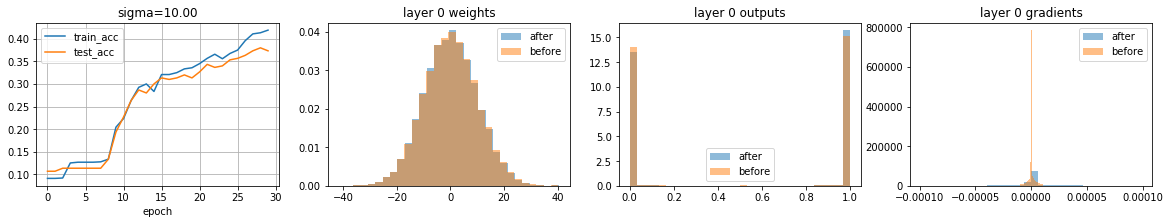

In [ ]:
train_experiment(model, sigma=10, X_train=X_train, X_test=X_test)

### initializing with a small $\sigma$ but with large values for input data

Recall that $XW+b$ is what enters the $sigmoid$ function. If large, it will be away from the linear regine around zero. It can be large because of $W$ (large initialization $\sigma$), or because of $X$.


W0220 17:51:39.917109 4736255424 base_layer.py:1790] Layer Layer_00_Input is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



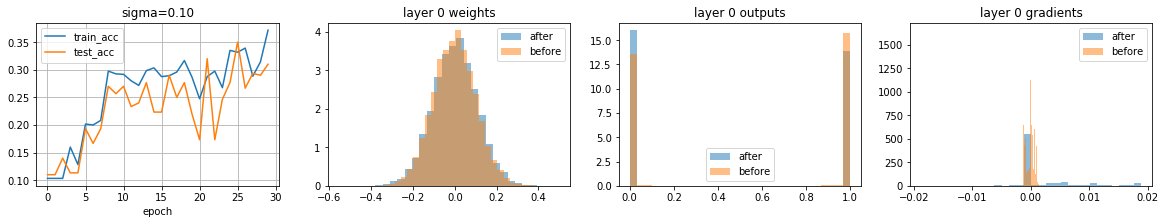

In [ ]:
train_experiment(model, sigma=.1, X_train=X_train*100-50, X_test=X_test*100-50)